In [3]:
import matplotlib.pyplot as plt
import os, re
import scipy.io
from collections import defaultdict
import numpy as np

import pandas as pd

def RMSE(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

def nested_dict(n):
    if n == 1:
        return defaultdict(lambda: np.ndarray(0))
    else:
        return defaultdict(lambda: nested_dict(n-1))

TypeError: 'module' object is not callable

### Whole-Image Human Attention Maps

In [2]:
human_attention_path = {
    "DET":{
        'vehicle': '/mnt/h/OneDrive - The University Of Hong Kong/bdd/attention_maps/231206 Veh DET/whole_image',
        'human':'/mnt/h/OneDrive - The University Of Hong Kong/bdd/attention_maps/231206 Hum DET/whole_image',
    },
    "DET-Cropped":{
        'vehicle': '/mnt/h/OneDrive - The University Of Hong Kong/bdd/attention_maps/231206 Veh DET/cropped',
        'human':'/mnt/h/OneDrive - The University Of Hong Kong/bdd/attention_maps/231206 Hum DET/cropped',
    },
    "EXP":{
        'vehicle':'/mnt/h/OneDrive - The University Of Hong Kong/bdd/results/explanation/231018_vehicle_whole_screen_vb_fixed_pos/human_saliency_map',
        'human':'/mnt/h/OneDrive - The University Of Hong Kong/bdd/results/explanation/231018_human_whole_screen_vb_fixed_pos/human_saliency_map',
    }
}

# Attention Type, Category, Image Idex
human_attention = {
    "DET": defaultdict(defaultdict),
    "DET-Cropped": defaultdict(defaultdict),
    "EXP": defaultdict(defaultdict),
}

for type, path_by_type in human_attention_path.items():
    for category, path in path_by_type.items():
        for file in os.listdir(path):
            img_idx = re.findall(r'\d+',file)[0]
            mat = scipy.io.loadmat(os.path.join(path,file))
            human_attention[type][category][img_idx] = mat['output_map_norm']

In [61]:
human_attention[type]['vehicle'].keys()

dict_keys(['1007', '100', '1023', '1026', '1028', '1031', '1041', '1043', '1047', '1065', '1079', '1090', '1099', '1100', '1108', '1109', '1112', '1114', '1121', '1127', '113', '1145', '1149', '1170', '1178', '117', '1183', '1201', '1209', '1211', '1223', '1226', '1232', '1236', '1252', '1253', '1258', '126', '1272', '1278', '1319', '1331', '133', '1344', '134', '1353', '1356', '1357', '1365', '141', '171', '178', '180', '183', '188', '192', '209', '210', '222', '241', '245', '269', '273', '274', '293', '297', '30', '321', '327', '329', '33', '342', '344', '355', '362', '36', '376', '381', '383', '388', '390', '3', '401', '406', '407', '425', '431', '437', '441', '447', '452', '478', '485', '49', '503', '505', '514', '52', '542', '54', '559', '570', '585', '600', '610', '611', '617', '629', '634', '648', '668', '66', '670', '67', '68', '692', '698', '699', '711', '715', '727', '740', '74', '758', '764', '777', '784', '796', '797', '803', '804', '822', '833', '838', '842', '843', '848',

In [3]:
xai_saliency_path = {
    "FullGradCAM":{
        'vehicle': '/mnt/h/Projects/HKU_XAI_Project/Yolov5self_GradCAM_Pytorch_1/multi_layer_analysis/results/vehicle/fullgradcamraw_class',
        'human': '/mnt/h/Projects/HKU_XAI_Project/Yolov5self_GradCAM_Pytorch_1/multi_layer_analysis/results/human/fullgradcamraw_class',
    },
    "ODAM":{
        'vehicle': '/mnt/h/Projects/HKU_XAI_Project/Yolov5self_GradCAM_Pytorch_1/multi_layer_analysis/odam_test_results',
        'human' : '/mnt/h/jinhan/xai/yolov5BDD/multi_layer_analysis/odam_test_results',
    }
}

# Type, Category, Layer, Image
xai_saliency_maps = {
    "FullGradCAM":{
        'vehicle': defaultdict(defaultdict),
        'human': defaultdict(defaultdict),
    },
    "ODAM":{
        'vehicle': defaultdict(defaultdict),
        'human' : defaultdict(defaultdict),
    }
}

for type, path_by_type in xai_saliency_path.items():
    for category, path in path_by_type.items():
        for dir in os.listdir(path):
            layer_num = int(re.findall(r"F\d+",dir)[-1].replace('F',''))

            for file in os.listdir(os.path.join(path,dir)):
                if '.mat' not in file: continue
                img_idx = re.findall(r'\d+-',file)[-1].replace('-','')
                mat = scipy.io.loadmat(os.path.join(path,dir,file))
                xai_saliency_maps[type][category][layer_num][img_idx] = mat['masks_ndarray']

In [6]:
for type, t in xai_saliency_maps.items():
    for category, c in t.items():
        # for layer, l in c.items():
            print(f"{type}  {category} {len(c)}")

FullGradCAM  vehicle 17
FullGradCAM  human 17
ODAM  vehicle 17
ODAM  human 17


## Similarity Analysis

In [4]:
PCC_all = {
    "DET vs FullGradCam":{
        'vehicle': defaultdict(defaultdict),
        'human': defaultdict(defaultdict),
    },
    "DET-Cropped vs ODAM":{
        'vehicle': defaultdict(defaultdict),
        'human' : defaultdict(defaultdict),
    },
    "EXP vs ODAM":{
        'vehicle': defaultdict(defaultdict),
        'human' : defaultdict(defaultdict),
    }
}
RMSE_all = {
    "DET vs FullGradCam":{
        'vehicle': defaultdict(defaultdict),
        'human': defaultdict(defaultdict),
    },
    "DET-Cropped vs ODAM":{
        'vehicle': defaultdict(defaultdict),
        'human' : defaultdict(defaultdict),
    },
    "EXP vs ODAM":{
        'vehicle': defaultdict(defaultdict),
        'human' : defaultdict(defaultdict),
    }
}

for category in ['vehicle','human']:
    for layer in range(1,18):
        for img in human_attention['DET'][category].keys():
            # DET vs FullGradCam
            PCC_all['DET vs FullGradCam'][category][layer][img] = np.corrcoef(xai_saliency_maps['FullGradCAM'][category][layer][img].flatten(), human_attention['DET'][category][img].flatten())[0,1]
            RMSE_all['DET vs FullGradCam'][category][layer][img] = RMSE(xai_saliency_maps['FullGradCAM'][category][layer][img].flatten(), human_attention['DET'][category][img].flatten())

            # DET-Cropped vs ODAM
            PCC_all['DET-Cropped vs ODAM'][category][layer][img] = np.corrcoef(xai_saliency_maps['ODAM'][category][layer][img].flatten(), human_attention['DET-Cropped'][category][img].flatten())[0,1]
            RMSE_all['DET-Cropped vs ODAM'][category][layer][img] = RMSE(xai_saliency_maps['ODAM'][category][layer][img].flatten(), human_attention['DET-Cropped'][category][img].flatten())

            # EXP vs ODAM
            PCC_all['EXP vs ODAM'][category][layer][img] = np.corrcoef(xai_saliency_maps['ODAM'][category][layer][img].flatten(), human_attention['EXP'][category][img].flatten())[0,1]
            RMSE_all['EXP vs ODAM'][category][layer][img] = RMSE(xai_saliency_maps['ODAM'][category][layer][img].flatten(), human_attention['EXP'][category][img].flatten())

In [5]:
PCC_layer_mean = defaultdict(defaultdict)
RMSE_layer_mean = defaultdict(defaultdict)

for analysis in PCC_all.keys():
    for category in ['vehicle','human']:
        PCC_layer_mean[analysis][category] = pd.DataFrame.from_dict(PCC_all[analysis][category]).mean(axis=0)
        RMSE_layer_mean[analysis][category] = pd.DataFrame.from_dict(RMSE_all[analysis][category]).mean(axis=0)


# PCC_layer_mean_veh = pd.DataFrame.from_dict(PCC_all['vehicle']).mean(axis=0)
# RMSE_layer_mean_veh = pd.DataFrame.from_dict(RMSE_all['vehicle']).mean(axis=0)

# PCC_layer_mean_hum = pd.DataFrame.from_dict(PCC_all['human']).mean(axis=0)
# RMSE_layer_mean_hum = pd.DataFrame.from_dict(RMSE_all['human']).mean(axis=0)

# PCC_layer_mean_all = pd.concat([pd.DataFrame.from_dict(PCC_all['vehicle']),pd.DataFrame.from_dict(PCC_all['human'])],ignore_index=True).mean(axis=0)
# RMSE_layer_mean_all = pd.concat([pd.DataFrame.from_dict(RMSE_all['vehicle']),pd.DataFrame.from_dict(RMSE_all['human'])],ignore_index=True).mean(axis=0)

In [6]:
# PCC_veh_sorted = PCC_layer_mean_veh.sort_index()
# RMSE_veh_sorted = RMSE_layer_mean_veh.sort_index()

# PCC_hum_sorted = PCC_layer_mean_hum.sort_index()
# RMSE_hum_sorted = RMSE_layer_mean_hum.sort_index()

# PCC_all_sorted = PCC_layer_mean_all.sort_index()
# RMSE_all_sorted = RMSE_layer_mean_all.sort_index()

PCC_sorted = defaultdict(defaultdict)
RMSE_sorted = defaultdict(defaultdict)

for analysis in PCC_all.keys():
    for category in ['vehicle','human']:
        PCC_sorted[analysis][category] = PCC_layer_mean[analysis][category].sort_index()
        RMSE_sorted[analysis][category] = RMSE_layer_mean[analysis][category].sort_index()

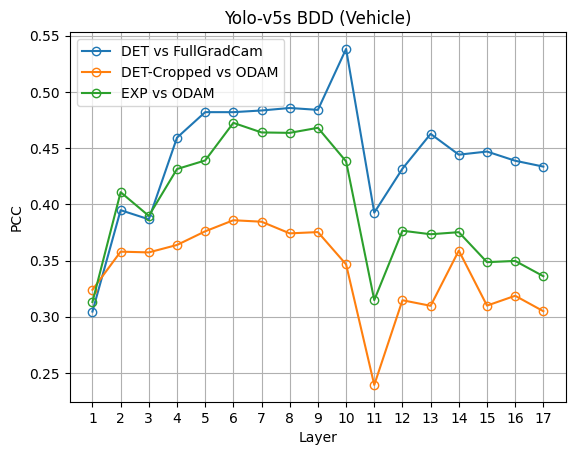

In [8]:
# Vehicle
plt.figure()
for analysis in PCC_all.keys():
# for analysis in ['DET vs FullGradCam','EXP vs ODAM']:
    plt.plot(PCC_sorted[analysis]['vehicle'].index, PCC_sorted[analysis]['vehicle'].values, marker='o',fillstyle='none',label=analysis)
plt.ylim((0,0.55))
plt.xticks(PCC_sorted[analysis]['vehicle'].index)
plt.grid()
plt.legend()
plt.xlabel('Layer')
plt.ylabel('PCC')
plt.title("Yolo-v5s BDD (Vehicle)")
plt.show()

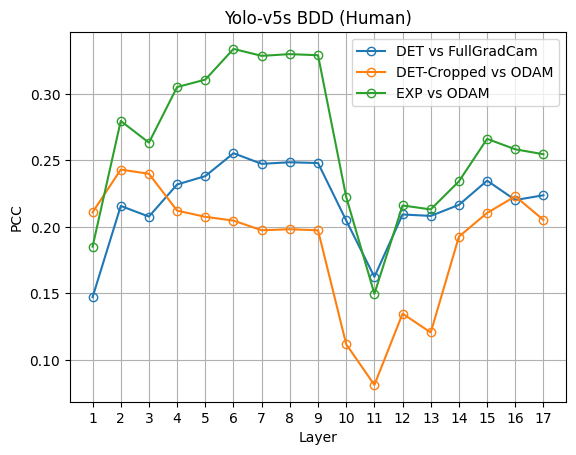

In [15]:
# Vehicle
plt.figure()
for analysis in PCC_all.keys():
    plt.plot(PCC_sorted[analysis]['human'].index, PCC_sorted[analysis]['human'].values, marker='o',fillstyle='none',label=analysis)
# plt.ylim((0.2,0.8))
plt.xticks(PCC_sorted[analysis]['human'].index)
plt.grid()
plt.legend()
plt.xlabel('Layer')
plt.ylabel('PCC')
plt.title("Yolo-v5s BDD (Human)")
plt.show()

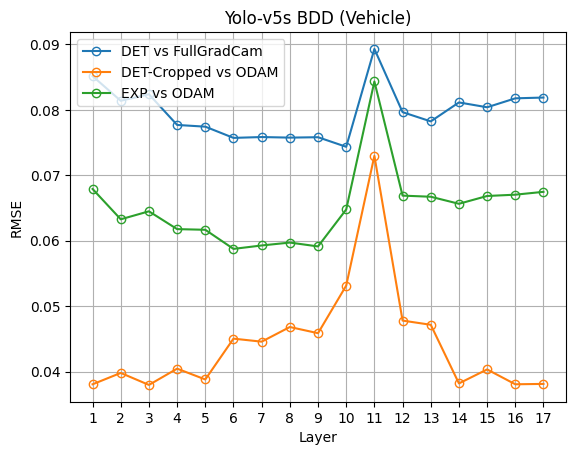

In [16]:
# Vehicle
plt.figure()
for analysis in RMSE_all.keys():
    plt.plot(RMSE_sorted[analysis]['vehicle'].index, RMSE_sorted[analysis]['vehicle'].values, marker='o',fillstyle='none',label=analysis)
# plt.ylim((0.2,0.8))
plt.xticks(RMSE_sorted[analysis]['vehicle'].index)
plt.grid()
plt.legend()
plt.xlabel('Layer')
plt.ylabel('RMSE')
plt.title("Yolo-v5s BDD (Vehicle)")
plt.show()

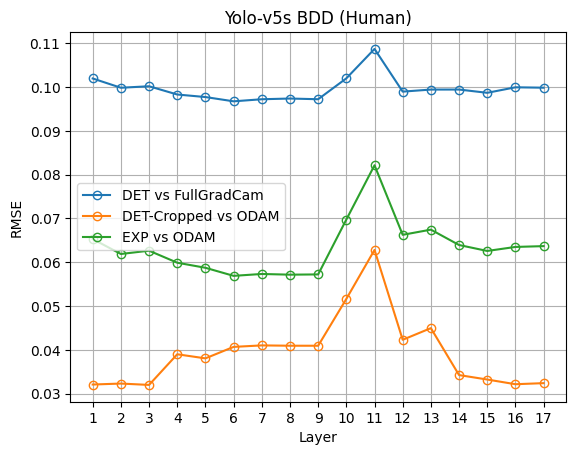

In [17]:
# Vehicle
plt.figure()
for analysis in RMSE_all.keys():
    plt.plot(RMSE_sorted[analysis]['human'].index, RMSE_sorted[analysis]['human'].values, marker='o',fillstyle='none',label=analysis)
# plt.ylim((0.2,0.8))
plt.xticks(RMSE_sorted[analysis]['human'].index)
plt.grid()
plt.legend()
plt.xlabel('Layer')
plt.ylabel('RMSE')
plt.title("Yolo-v5s BDD (Human)")
plt.show()